In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn import metrics
import time
import tensorflow as tf
import shap
import numpy as np
tf.compat.v1.disable_v2_behavior()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# load model
from keras.models import load_model
model = load_model('lstm_bin.h5')

# load binary model
data = pd.read_csv('kdd_processed_bin.csv')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-12-24 12:12:55.130026: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-24 12:12:55.199756: W tensorflow/c/c_api.cc:304] Operation '{name:'dense/bias/Assign' id:547 op device:{requested: '', assigned: ''} def:{{{node dense/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense/bias, dense/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-24 12:12:55.327224: W tensorflow/c/c_api.cc:304] Operation '{name:'dense/kernel/v/Assign' id:808 op device:{requested: '', assigned: ''} def:{{{node dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense/kernel/v, dense/kernel/v/Initializer/zeros)}}' was changed b

In [ ]:
X = data.drop('class', axis=1)
Y = data['class']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

In [6]:
import matplotlib.pyplot as plt
# tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

tf.compat.v1.disable_v2_behavior()
# # reset graph
# tf.compat.v1.reset_default_graph()

#  get keras session of the model
sess = tf.compat.v1.keras.backend.get_session()

# Create a DeepExplainer with Python lists
explainer = shap.DeepExplainer(model, X_train[:100], session=sess)

# Get Shapley values with Python lists
shap_values = explainer.shap_values(X_test[:10000])

# Rest of your code
shap.getjs()
shap.initjs()
features = X.columns.to_list()

# Use Python lists for force_plot
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


40


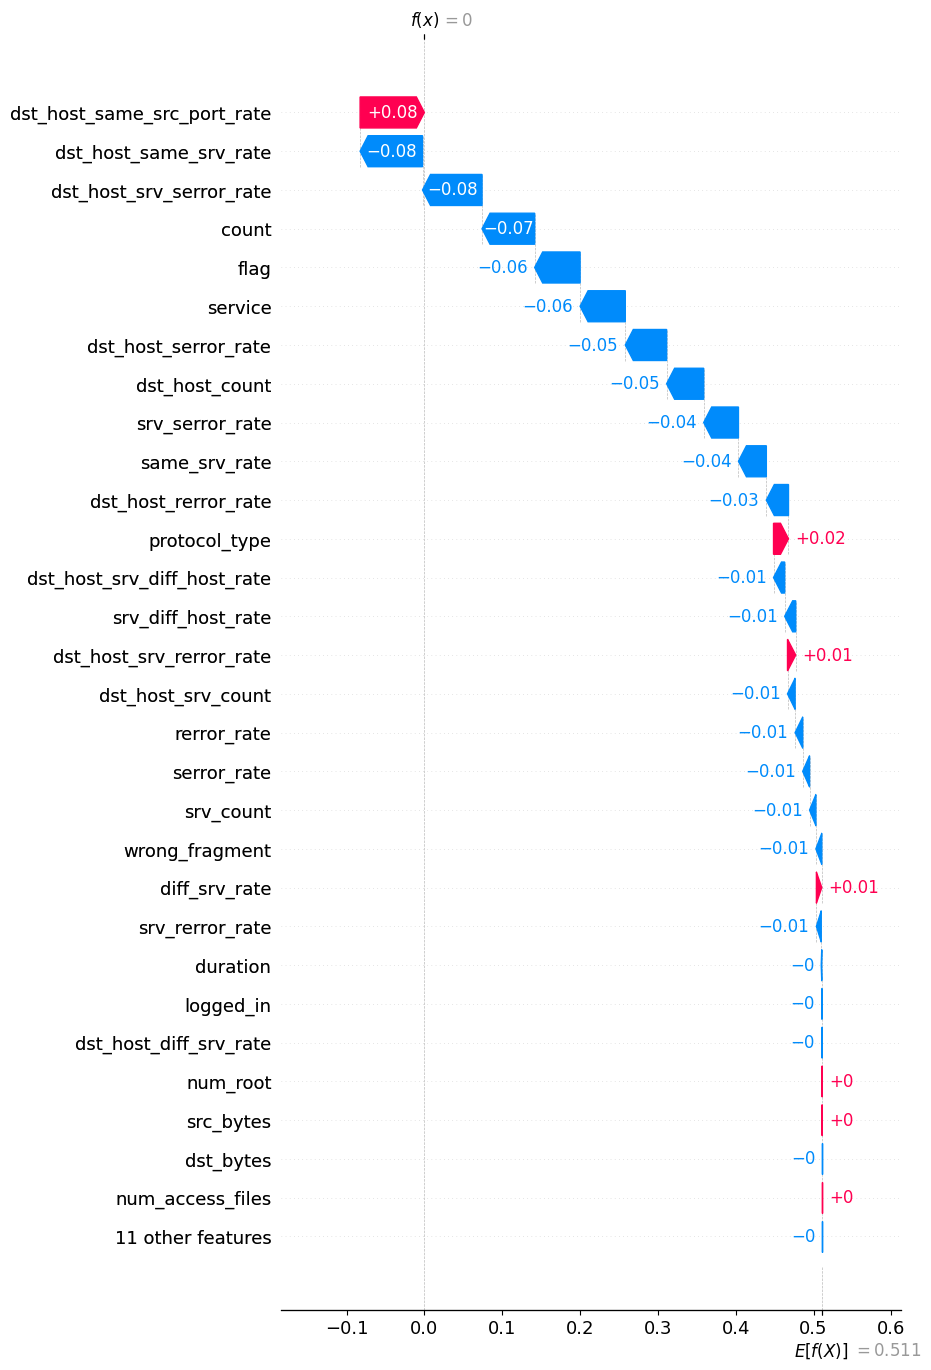

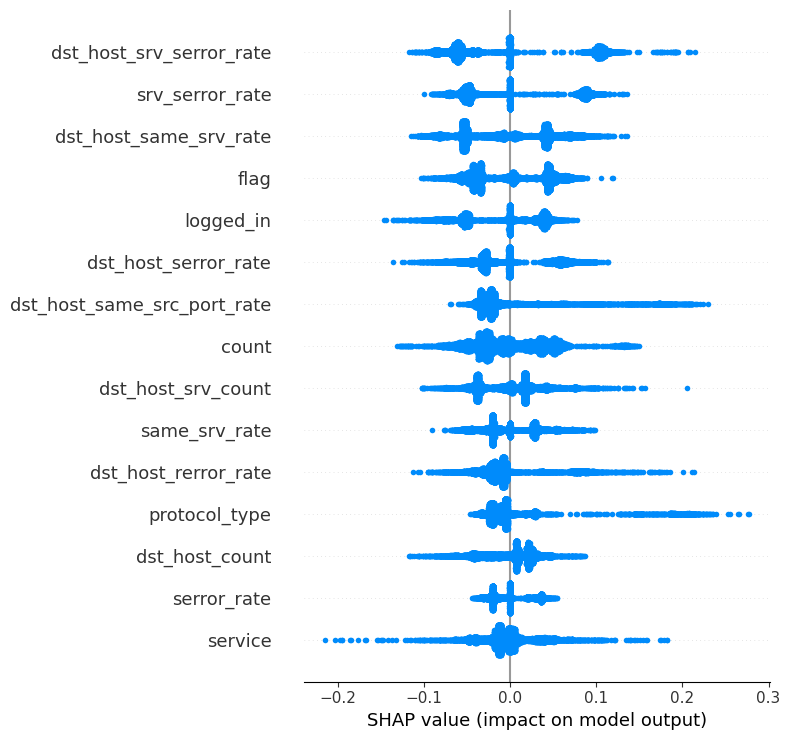

In [7]:
# display shap graph 
vals = shap_values[0]
# reshaping the values
vals = vals.reshape((vals.shape[0], vals.shape[2]))
print(len(vals[0]))
shap.waterfall_plot(shap.Explanation(values=vals[0], base_values=explainer.expected_value[0], feature_names=features), max_display = 30)
# shap.bar_plot(vals[0], feature_names=features, max_display=30)
shap.summary_plot(vals, feature_names=features, max_display=15)

In [8]:
# get top 15 features
top_15 = np.argsort(np.sum(np.abs(vals), axis=0))[-15:]
print(top_15)

# keep only top 15 features
data2 = data.copy()
data2 = data2.iloc[:,top_15]
data2['class'] = data['class']

[ 2 23 30  1 38 27 31 21 34 36 11  3 32 24 37]


In [ ]:
# save data2
data2.to_csv('kdd_processed_bin_top15.csv', index=False)

In [10]:
# train an lstm model on the data
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn import metrics
X = data2.drop('class', axis=1)
Y = data2['class']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)


# define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start = time.time()
# train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), shuffle=True)
end = time.time()
print("Time taken to train the model: ", end - start)

Train on 100778 samples, validate on 25195 samples
Epoch 1/10


2023-12-24 12:13:36.567085: W tensorflow/c/c_api.cc:304] Operation '{name:'total_1/Assign' id:2893 op device:{requested: '', assigned: ''} def:{{{node total_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_1, total_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


100320/100778 [============================>.] - ETA: 0s - loss: 0.1216 - acc: 0.9564

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-12-24 12:13:42.814582: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:2945 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


100778/100778 [==============================] - 7s 66us/sample - loss: 0.1214 - acc: 0.9565 - val_loss: 0.0834 - val_acc: 0.9717
Epoch 2/10
100778/100778 [==============================] - 6s 58us/sample - loss: 0.0778 - acc: 0.9723 - val_loss: 0.0630 - val_acc: 0.9748
Epoch 3/10
100778/100778 [==============================] - 6s 57us/sample - loss: 0.0635 - acc: 0.9766 - val_loss: 0.0551 - val_acc: 0.9786
Epoch 4/10
100778/100778 [==============================] - 5s 53us/sample - loss: 0.0544 - acc: 0.9798 - val_loss: 0.0497 - val_acc: 0.9812
Epoch 5/10
100778/100778 [==============================] - 5s 51us/sample - loss: 0.0481 - acc: 0.9820 - val_loss: 0.0392 - val_acc: 0.9859
Epoch 6/10
100778/100778 [==============================] - 5s 51us/sample - loss: 0.0442 - acc: 0.9839 - val_loss: 0.0406 - val_acc: 0.9855
Epoch 7/10
100778/100778 [==============================] - 5s 51us/sample - loss: 0.0411 - acc: 0.9849 - val_loss: 0.0377 - val_acc: 0.9866
Epoch 8/10
100778/100778

In [11]:
start_test = time.time()
y_pred = model.predict(X_test)
end_test = time.time()
y_pred = (y_pred > 0.5)
print('Classification Report')
print(metrics.classification_report(Y_test, y_pred))
print('Accuracy:')
print(metrics.accuracy_score(Y_test, y_pred))
print("Time taken to predict: ", end_test - start_test)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-12-24 12:14:31.197206: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Sigmoid' id:2888 op device:{requested: '', assigned: ''} def:{{{node dense_1/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     13422
           1       0.99      0.99      0.99     11773

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195

Accuracy:
0.9882913276443739
Time taken to predict:  0.49436378479003906
